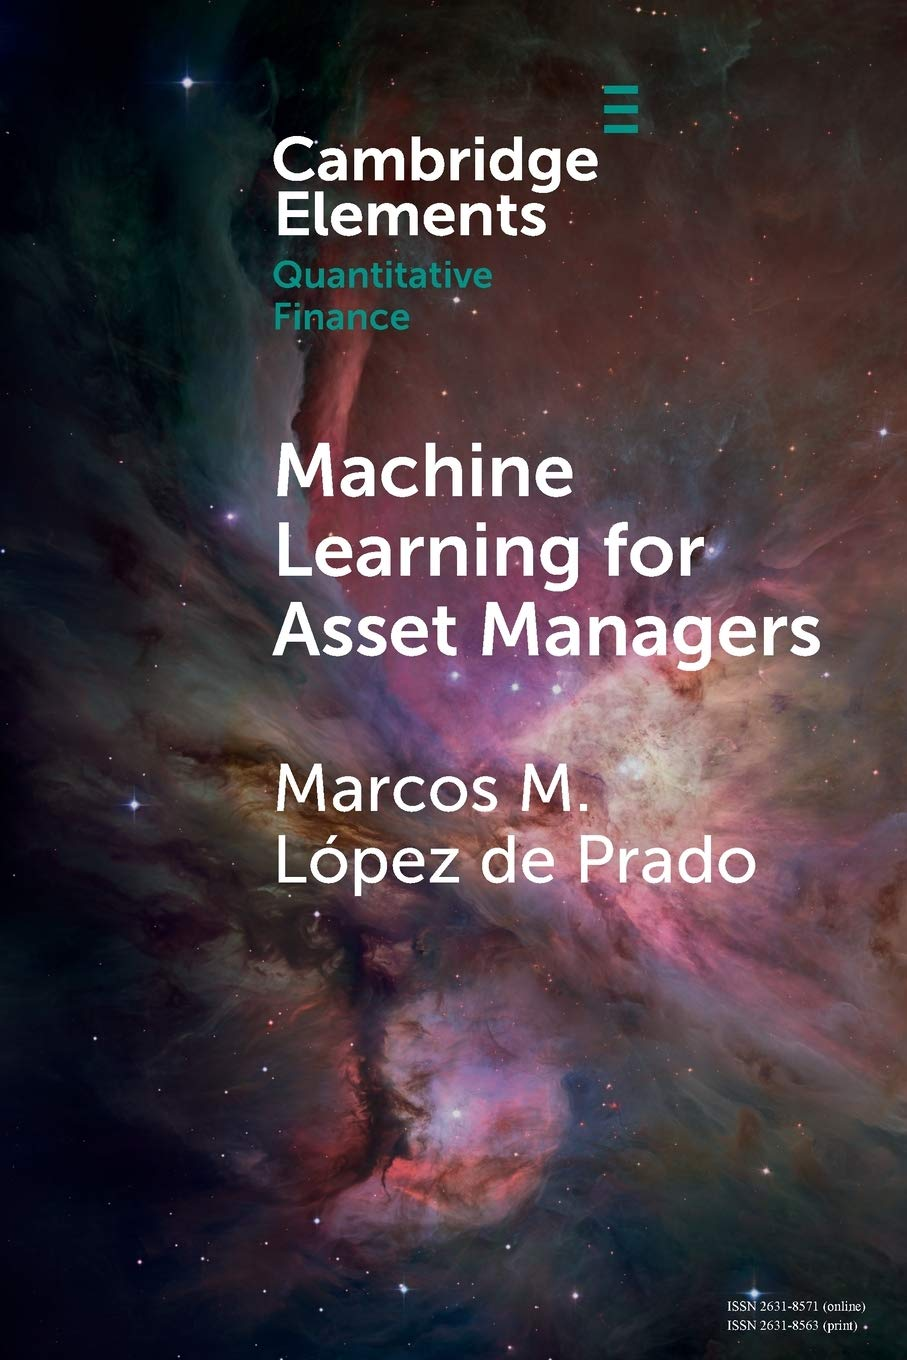

# Target Analysis and Denoising


I haven't seen many attempts at target engineering so I felt like I could share an initial analysis and my current work around denoising the target. Maybe it will prove usefull, maybe it will inspire others. Those denoising techniques seems to generally improve a bit my model scores and reduce variance across folds when used as a base for binary classification. I haven't had the time to test for regression or compare it to stacking multiple targets.

The notebook start with a simple analysis and a basic linear approach I came up with. Then I'll go into a deeper approach that rely on random matrix theory. In his "Machine Learning for Asset Managers", Marcos M. López de Prado show how to use Random Matrix Theory to denoise a covariance matrix. By removing eigenvalues from the covariance matrix it is possible to also reduce the dimension of the initial inputs. It has already been used [here](https://www.kaggle.com/fernandoramacciotti/janestreet-denoising-rmt) to denoise the features covariance matrix and reduce the associated dimension of the problem. In this notebook I show how to use it for reducing noise in targets.

I hope you will enjoy this target engineering notebook as much as my previous works (About [Intraday Feature Exploration](https://www.kaggle.com/lucasmorin/complete-intraday-feature-exploration),[Running Algorithms for Fast Feature Engineering](https://www.kaggle.com/lucasmorin/running-algos-fe-for-fast-inference), and [using yfinance to download financial data in Ptyhon](https://www.kaggle.com/lucasmorin/downloading-market-data)). Feel free to upvote / share my notebooks.
Lucas

### Skip to Main Sections:
- [Target Analysis](#Target_Analysis)
- [Target Denoising with Linear Regression](#Target_Denoising_linear)
- [Marcenko-Pastur Theorem - Denoising Technique](#Denoising_Technique)
- [Target Denoising with Random Matrix theory](#Target_Denoising_RMT)


### Loading data 

Loading a pickle file. Check this notebook [pickling](https://www.kaggle.com/quillio/pickling) if you haven't pickled your data set yet. Check this notebook [one liner to halve your memory usage](https://www.kaggle.com/jorijnsmit/one-liner-to-halve-your-memory-usage) if you want to reduce memory usage before pickling.

In [ ]:
%%time

import pickle 
import numpy as np
import pandas as pd

train_pickle_file = '/kaggle/input/pickling/train.csv.pandas.pickle'
data = pickle.load(open(train_pickle_file, 'rb'))

<a id='Target_Analysis'></a>
# Target Analysis

Let's have a look at targets. In Financial Machine Learning it is usual to build a target by looking at the behavior of a financial instrument over a given time horizon. We already know from other notebooks (for exemple here : https://www.kaggle.com/marketneutral/target-engineering-cv-multi-target), that different target correspond to different time horizons. The horizon of the main target seems to be between the horizon of target 3 and 4. We can indeed observe that :   

In [ ]:
targets = ['resp','resp_1','resp_2','resp_3','resp_4']

data[targets].head()

As we only need to output a binary action, transforming the target into binary results is the first step. Looking at (and counting) patterns might be helpfull to understand what is happeing : 

In [ ]:
targets_arr = data[targets].values
targets_bool_arr = targets_arr>0

targets_bool_arr[:5,:]

my_map = {True: 'Y', False: 'N'}
target_str_arr = np.vectorize(my_map.get)(targets_bool_arr)
target_str_arr_join = ["".join(i) for i in target_str_arr[:,:].astype(str)]

data['pattern'] = target_str_arr_join

data.pattern.value_counts()

We see that resp, mostly correlate to the last two resp_i. We find that higher return are associated with more ones in the different responses.

In [ ]:
data.groupby('pattern').mean().resp

I suspected that weight had to do with variance. But removing weight 0 removes a lot of values at the top with clear trend (YYYYY or NNNNN). Not sure how to interpret that. 

In [ ]:
data.query('weight!=0').pattern.value_counts()

<a id='Target_Denoising_linear'></a>
# Linear denoising

I start with a simple I had in mind would be to try to predict the main response from others. I wasn't sure about this technique, notably because I wanted to take resp_i horizons or volatility into account. But I figured that any correction would be a multiplicative constant that wouldn't change the result of a linear regression. 

So the main idea is to perform a regression of resp on other resp_i, to find what would be the expected resp. Denoising might then come from modifying the actual value with the expected one. 

In [ ]:
from sklearn.linear_model import LinearRegression

tgt = ['resp_1','resp_2','resp_3','resp_4']

X = data[tgt]
y = data['resp']

reg = LinearRegression().fit(X, y)

reg.coef_
reg.intercept_
l_resp = reg.predict(X)

data['l_resp'] = l_resp

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y,l_resp)

Not that bad. We might directly use the prediction. Or we might use a partially denoised version, to keep a bit of noise. (It seems that in fact I have better results with mainly noisy variable + a bit of denoising, ie setting the c value to value near 1)

In [ ]:
c = 0.9

data['c_resp'] = c * data['resp'] + (1-c) * data['l_resp']

In [ ]:
plt.scatter(data['resp'],data['c_resp'])

<a id='Denoising_Technique'></a>
# Marcenko-Pastur Theorem - Denoising Technique

The denoising technique rely on the Marcenko-Pastur Theorem. Given a matrix X of iid observations of size TxN, where the underlying generating proce is centered (mean = 0) and has variance $\sigma^2$. the Matrix $C = \frac{1}{T}X^T X$ has eigenvalues $\lambda$ that assymptotically converge to the Marcenko-Pastur density (as both T and N tend towards $+\infty$, with $1 < \frac{T}{N} < +\infty$). 

The Marcenko-Pastur density is given by:

$ f(\lambda) = \frac{T}{N} \frac{\sqrt{(\lambda_{+}-\lambda)(\lambda-\lambda_{-})}}{2 \pi \lambda \sigma^2} $ if $ \lambda \in [\lambda_{-},\lambda_{+}]$ 

$ f(\lambda) = 0 $ else

Where $\lambda_{+/-} = \sigma^2 (1 +/- \sqrt{ \frac{N}{T} })^2$

If $\sigma = 1$, then C is the correlation matrix associated with X.

This give a general distribution for comparison. Assuming that $\lambda \in [\lambda_{-},\lambda_{+}]$ is associated with noise we can remove those eigenvalues. (We can also remove the main eigenvalues, which is associated with a market wise component).

The graph below (from https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3469961) show which eigenvalues correspond to the marcenko pastur distirbution. The idea is too keep only those that are in the right side of the graph. 

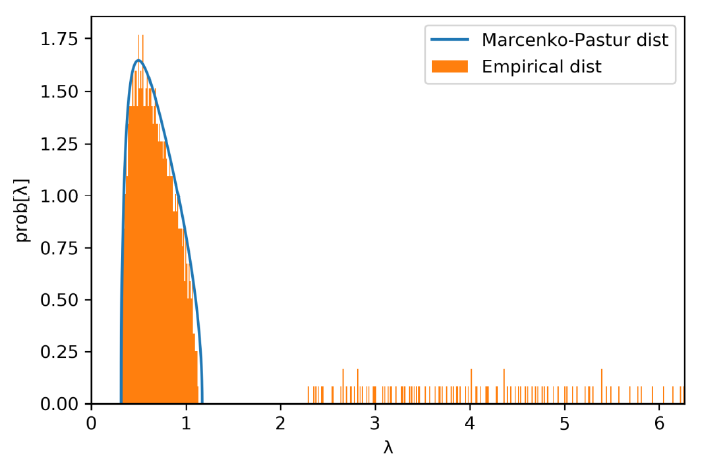

From https://www.kaggle.com/fernandoramacciotti/janestreet-denoising-rmt:

In [ ]:
# Snippets from Marco Lopez de Prado, 2020

from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity

def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin, eMax = var*(1-(1./q)**.5)**2, var*(1+(1./q)**.5)**2
    eVal = np.linspace(eMin,eMax,pts)
    pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf = pd.Series(pdf.reshape(-1,), index=eVal.reshape(-1,))
    return pdf


def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec = np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec

def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:
        obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1,)
    if len(x.shape)==1:
        x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    return sse

def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko’s dist
    out=minimize(lambda *x:errPDFs(*x),.5,args=(eVal,q,bWidth),
    bounds=((1E-5,1-1E-5),))
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax,var

def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

def denoisedCorr2(eVal,eVec,nFacts,alpha=0):
    # Remove noise from corr through targeted shrinkage
    eValL,eVecL=eVal[:nFacts,:nFacts],eVec[:,:nFacts]
    eValR,eVecR=eVal[nFacts:,nFacts:],eVec[:,nFacts:]
    corr0=np.dot(eVecL,eValL).dot(eVecL.T)
    corr1=np.dot(eVecR,eValR).dot(eVecR.T)
    corr2=corr0+alpha*corr1+(1-alpha)*np.diag(np.diag(corr1))
    return corr2

from sklearn.base import BaseEstimator, TransformerMixin

#@njit
def fillna_npwhere_njit(array, values):
    if np.isnan(array.sum()):
        array = np.where(np.isnan(array), values, array)
    return array

class RMTDenoising(BaseEstimator, TransformerMixin):
    
    def __init__(self, bWidth=.01, alpha=.5, feature_0=True, sample=0.3, seed=2021):
        self.bWidth = bWidth
        self.alpha = alpha
        self.feature_0 = feature_0
        self.sample = sample
        self.seed = seed
    
    def denoise(self, X):
        sample = X.sample(frac=self.sample, random_state=self.seed)
        q = X.shape[0] / X.shape[1]
        cov = sample.cov().values
        corr0 = cov2corr(cov)

        eVal0, eVec0 = getPCA(corr0)
        eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=self.bWidth)
        nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
        corr1 = denoisedCorr2(eVal0,eVec0,nFacts0,alpha=self.alpha)
        eVal1, eVec1 = getPCA(corr1)
        #result = np.hstack((np.diag(eVal1), var0))
        #name = [f'eigen_{i+1}' for i in range(len(eVal1))] + ['var_explained']
        return eVec1[:, :nFacts0]
    
    def fit(self, X, y=None):
        if self.feature_0:
            self.cols_ = [c for c in X.columns if c != 'feature_0']
        else:
            self.cols_ = list(X.columns)
        X_ = X[self.cols_]
        self.W_ = self.denoise(X_)
        self.dim_W_ = self.W_.shape[1]
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        names = [f'proj_{i}' for i in range(self.dim_W_)]
        projection = pd.DataFrame(fillna_npwhere_njit(X_[self.cols_].values, 0).dot(self.W_), columns=names)
        if self.feature_0:
            projection['feature_0'] = X['feature_0']
        return projection

<a id='Target_Denoising_RMT'></a>
# Target Denoising - RMT
We use the transformer to denoise the targets.

In [ ]:
targets_f0 = targets + ['feature_0']
target_tf = RMTDenoising(sample=0.8)

target_tf.fit(data[targets_f0])

Dn_targets = target_tf.transform(data[targets_f0])

Somehow the projection is of the wrong sign :

In [ ]:
Dn_targets.proj_0.head()

In [ ]:
data.resp.head()

In [ ]:
data['dresp'] = -Dn_targets.proj_0

In [ ]:
targets = ['dresp','resp_1','resp_2','resp_3','resp_4']

data[targets].head()

targets_arr = data[targets].values
targets_bool_arr = targets_arr>0

targets_bool_arr[:5,:]

my_map = {True: 'Y', False: 'N'}
target_str_arr = np.vectorize(my_map.get)(targets_bool_arr)
target_str_arr_join = ["".join(i) for i in target_str_arr[:,:].astype(str)]

data['dpattern'] = target_str_arr_join

data.pattern.value_counts()

We see that it removes some noise as we have more 'straighforward' targets (YYYYY or NNNNN). It seems to removes some edge case, but not all of them. 

# Conclusion

Those two approaches seems to bring some progress in the right direction, but I am not convinced this is the end of what we could do for target engineering. 